In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns


from src.reader import read_dataset, create_vocabulary, preprocess_data

sns.set_theme(style="ticks", palette="colorblind")


DATA_PATH = Path("./results/processed_full.jsonl")
OUTPUT_PATH = Path("./results/notebooks/cnn")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
MAX_SEQ_LENGTH = 500
RANDOM_SEED = 2025

print(f"Loading dataset from {DATA_PATH}...")
entries = read_dataset(DATA_PATH)
print(f"Loaded {len(entries)} code snippets")

print("Creating vocabulary from the dataset...")
vocabulary = create_vocabulary(DATA_PATH)
print(f"Vocabulary size: {len(vocabulary):,}")

sequence_lengths = [len(entry.tokens) for entry in entries]
max_observed_length = max(sequence_lengths)
mean_length = sum(sequence_lengths) / len(sequence_lengths)
print(f"Maximum observed sequence length: {max_observed_length}")
print(f"Average sequence length: {mean_length:.2f}")

X, y, class_names = preprocess_data(entries, vocabulary, MAX_SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=np.argmax(y, axis=1))

print(f"Class names: {class_names}")
print("\nData split:")
print(f"- Training: {X_train.shape[0]} samples")
print(f"- Test: {X_test.shape[0]} samples")


Loading dataset from results/processed_full.jsonl...
[Load] Parsed 5,127 LineItem objects from results/processed_full.jsonl (0 errors)
Loaded 5127 code snippets
Creating vocabulary from the dataset...
[Vocabulary] Total unique tokens: 3,915
Vocabulary size: 3,915
Maximum observed sequence length: 405
Average sequence length: 106.61
[Data] X(5127, 500), y(5127, 4) - classes: ['classes_for_data', 'idiomatic', 'null_checks', 'throws']
Class names: ['classes_for_data', 'idiomatic', 'null_checks', 'throws']

Data split:
- Training: 4101 samples
- Test: 1026 samples


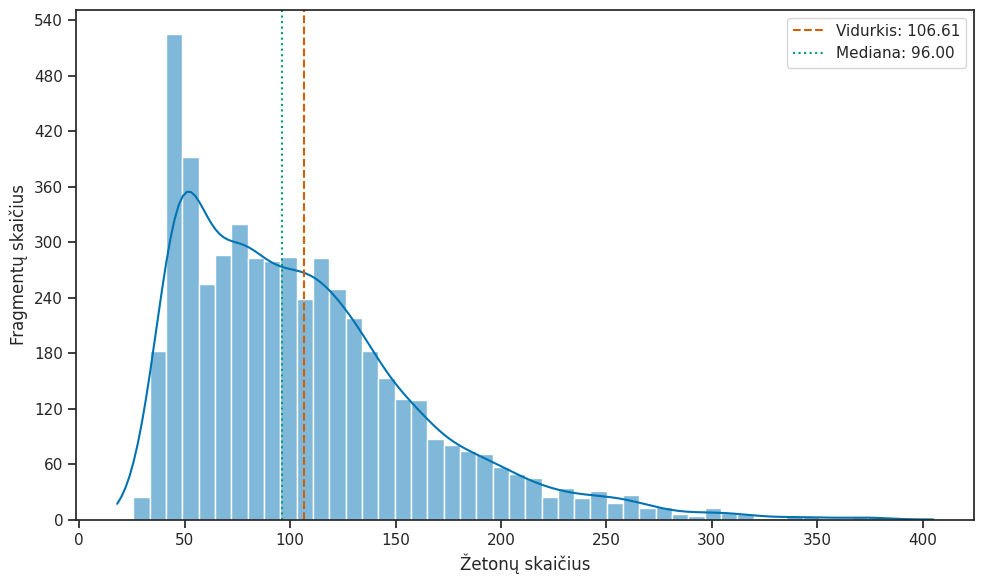

Snippet length distribution plot saved to results/notebooks/cnn/snippet_length_distribution.png


In [8]:
from matplotlib.ticker import MaxNLocator


plt.figure(figsize=(10, 6))
ax = sns.histplot(sequence_lengths, bins=50, kde=True)
plt.xlabel("Žetonų skaičius")
plt.ylabel("Fragmentų skaičius")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

mean_len = np.mean(sequence_lengths)
median_len = np.median(sequence_lengths)
plt.axvline(float(mean_len), color="r", linestyle="--", label=f"Vidurkis: {mean_len:.2f}")
plt.axvline(float(median_len), color="g", linestyle=":", label=f"Mediana: {median_len:.2f}")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_PATH / "snippet_length_distribution.png")
plt.close()
print(f"Snippet length distribution plot saved to {OUTPUT_PATH / 'snippet_length_distribution.png'}")

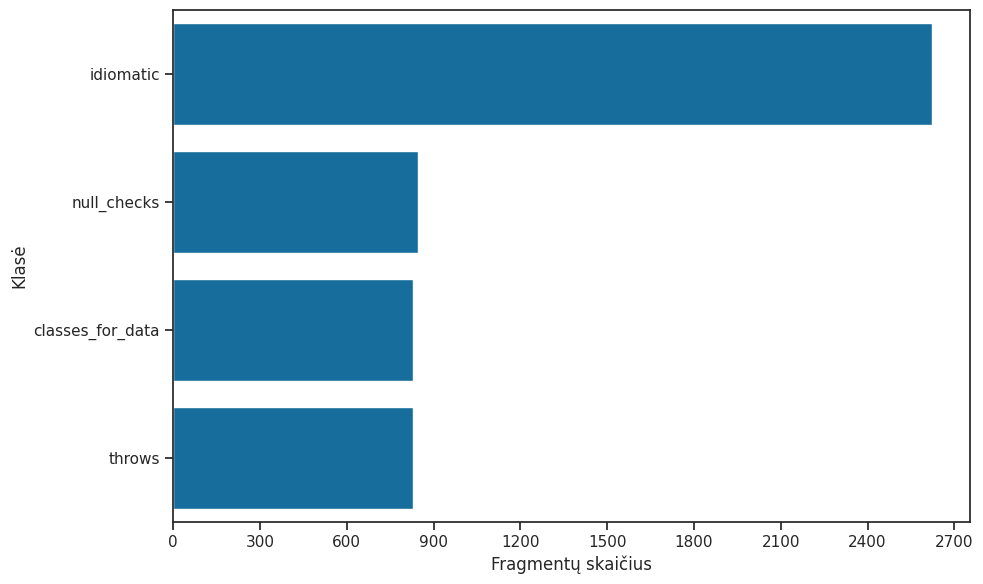

Class distribution plot saved to results/notebooks/cnn/class_distribution.png


In [9]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import seaborn as sns

y_indices = np.argmax(y, axis=1)
y_labels = [class_names[idx] for idx in y_indices]

df = pd.DataFrame({"class": y_labels})

plt.figure(figsize=(10, 6))
ax = sns.countplot(y="class", data=df, order=df["class"].value_counts().index)
plt.xlabel("Fragmentų skaičius")
plt.ylabel("Klasė")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig(OUTPUT_PATH / "class_distribution.png")
plt.show()
plt.close()
print(f"Class distribution plot saved to {OUTPUT_PATH / 'class_distribution.png'}")

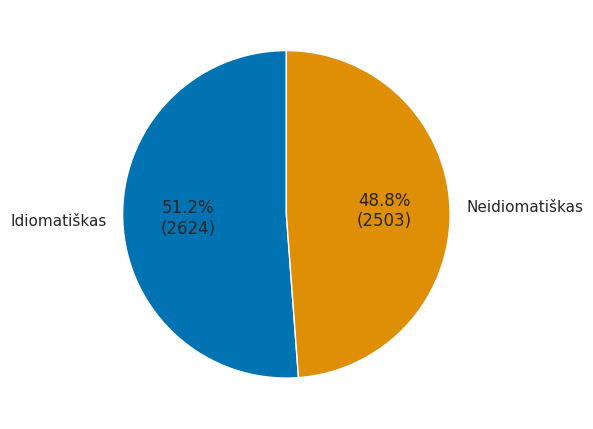

Idiomaticity distribution plot saved to results/notebooks/cnn/idiomaticity_distribution.png


In [17]:
import pandas as pd

is_idiomatic_list = [entry.label == "idiomatic" for entry in entries]
counts = pd.Series(is_idiomatic_list).value_counts()
labels = ["Idiomatiškas" if idx else "Neidiomatiškas" for idx in counts.index]

plt.figure(figsize=(6, 6))


def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({val:d})"

    return my_autopct


plt.pie(counts, labels=labels, autopct=make_autopct(counts), startangle=90)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "idiomaticity_distribution.png")
plt.show()
plt.close()
print(f"Idiomaticity distribution plot saved to {OUTPUT_PATH / 'idiomaticity_distribution.png'}")

In [11]:
import keras
from keras.api.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense

embedding_dim = 128
cnn_num_filters = 64
dropout_rate = 0.1
learning_rate = 0.0027785152357366148
filter_sizes = [3, 4, 5]

inputs = Input(shape=(MAX_SEQ_LENGTH,), name="input")
embedding = Embedding(input_dim=len(vocabulary), output_dim=embedding_dim, name="embedding")(inputs)

conv_blocks = []
for filter_size in filter_sizes:
    conv = Conv1D(
        filters=cnn_num_filters,
        kernel_size=filter_size,
        padding="valid",
        activation="relu",
        name=f"conv_{filter_size}",
    )(embedding)

    pool = GlobalMaxPooling1D(name=f"pool_{filter_size}")(conv)
    conv_blocks.append(pool)

concatenated = Concatenate(name="concatenate")(conv_blocks)
dropout = Dropout(dropout_rate, name="dropout")(concatenated)
outputs = Dense(len(class_names), activation="softmax", name="output")(dropout)
model = keras.Model(inputs=inputs, outputs=outputs)

print("\nModel Architecture:")
model.summary()
print(f"Total parameters: {model.count_params():,}")

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)  # type: ignore
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy", keras.metrics.F1Score(average="weighted", name="f1score")],
)



Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 500)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 128)  │    501,120 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv1D)     │ (None, 498, 64)   │     24,640 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv1D)     │ (None, 497, 64)   │     32,832 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv1D)     │ (None, 496, 64)   │     41,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_3              │ (None, 64)        │          0 │ conv_3[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_4              │ (None, 64)        │          0 │ conv_4[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_5              │ (None, 64)        │          0 │ conv_5[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ pool_3[0][0],     │
│ (Concatenate)       │                   │            │ pool_4[0][0],     │
│                     │                   │            │ pool_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 192)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        772 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 600,388 (2.29 MB)

 Trainable params: 600,388 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 600,388


In [12]:
from matplotlib.ticker import MaxNLocator

EPOCHS = 15
BATCH_SIZE = 32

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
)
model.save(OUTPUT_PATH / "best_model.keras")


Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8264 - f1score: 0.8032 - loss: 0.4807 - val_accuracy: 1.0000 - val_f1score: 1.0000 - val_loss: 0.0073
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9987 - f1score: 0.9987 - loss: 0.0068 - val_accuracy: 0.9981 - val_f1score: 0.9980 - val_loss: 0.0044
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9988 - f1score: 0.9988 - loss: 0.0042 - val_accuracy: 0.9981 - val_f1score: 0.9981 - val_loss: 0.0078
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - f1score: 1.0000 - loss: 0.0018 - val_accuracy: 0.9981 - val_f1score: 0.9980 - val_loss: 0.0105
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9989 - f1score: 0.9989 - loss: 0.0042 - val_accuracy: 0.9961 - val_f1score: 0.9961 - val_loss: 0.0163
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9985 - f1score: 0.9985 - loss: 0.0056 - val_accuracy: 0.9981 - val_f1score: 0.9980 - val

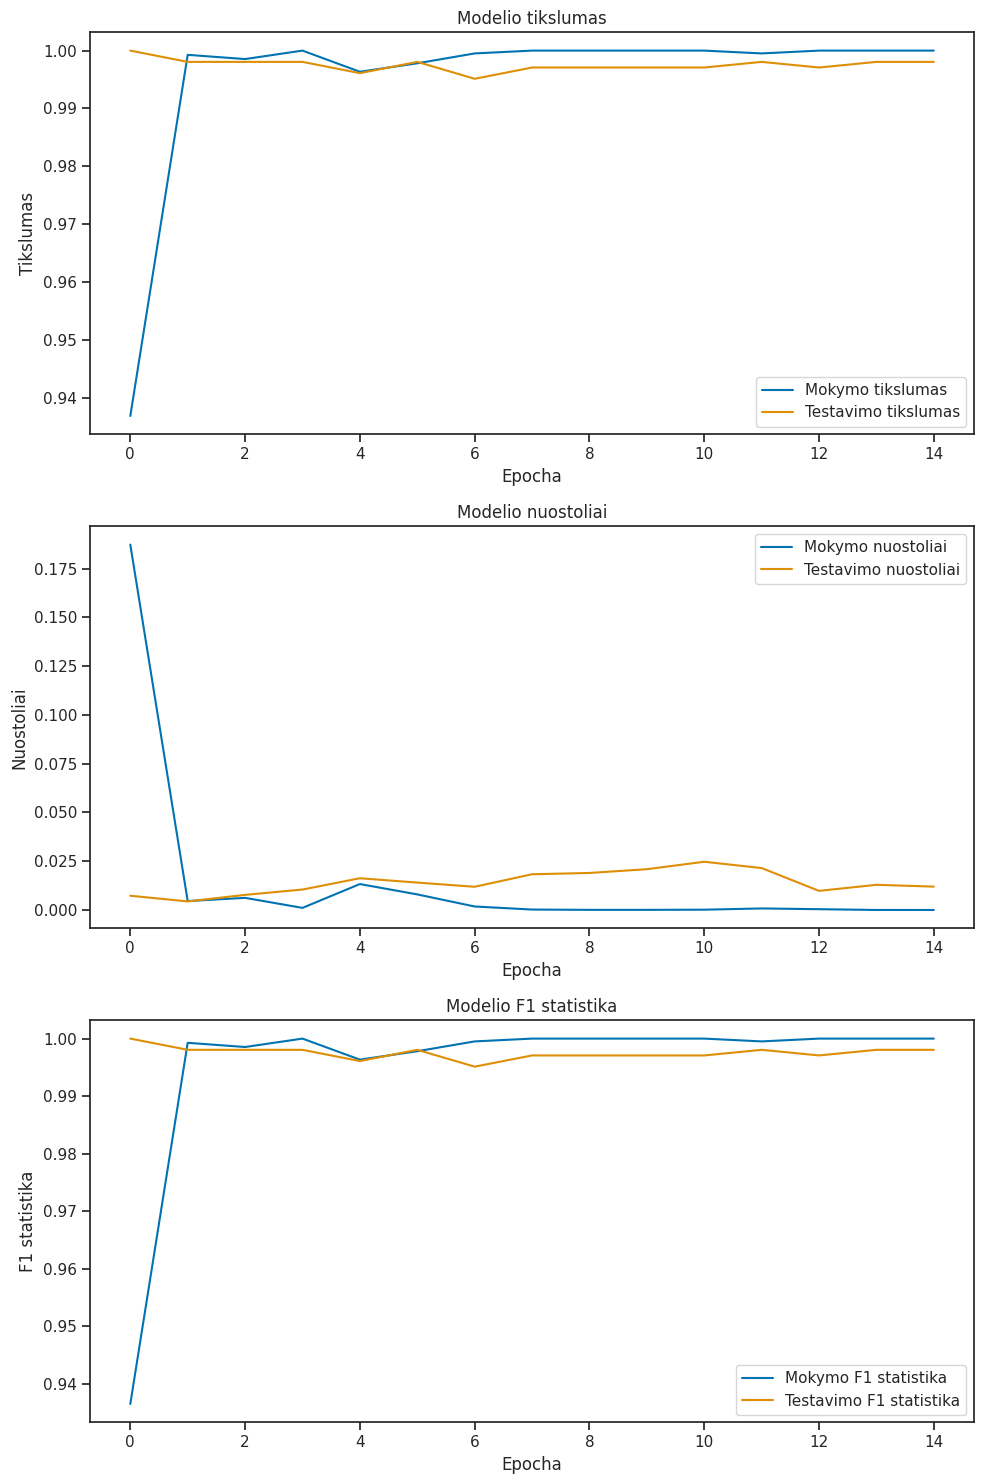

In [13]:
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.plot(history.history["accuracy"], label="Mokymo tikslumas")
plt.plot(history.history["val_accuracy"], label="Testavimo tikslumas")
plt.xlabel("Epocha")
plt.ylabel("Tikslumas")
plt.title("Modelio tikslumas")
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplot(3, 1, 3)
plt.plot(history.history["f1score"], label="Mokymo F1 statistika")
plt.plot(history.history["val_f1score"], label="Testavimo F1 statistika")
plt.xlabel("Epocha")
plt.ylabel("F1 statistika")
plt.title("Modelio F1 statistika")
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplot(3, 1, 2)
plt.plot(history.history["loss"], label="Mokymo nuostoliai")
plt.plot(history.history["val_loss"], label="Testavimo nuostoliai")
plt.xlabel("Epocha")
plt.ylabel("Nuostoliai")
plt.title("Modelio nuostoliai")
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


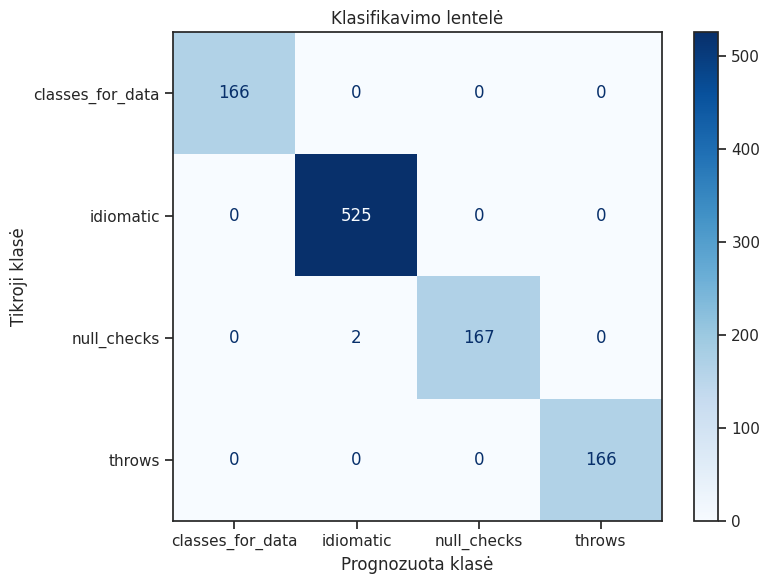

Klasifikacijos ataskaita:

                  precision    recall  f1-score   support

classes_for_data      1.000     1.000     1.000       166
       idiomatic      0.996     1.000     0.998       525
     null_checks      1.000     0.988     0.994       169
          throws      1.000     1.000     1.000       166

        accuracy                          0.998      1026
       macro avg      0.999     0.997     0.998      1026
    weighted avg      0.998     0.998     0.998      1026



In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Klasifikavimo lentelė")
plt.xlabel("Prognozuota klasė")
plt.ylabel("Tikroji klasė")
plt.tight_layout()
plt.show()

print("Klasifikacijos ataskaita:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

Metrikų lentelė išsaugota: results/notebooks/cnn/metrics_table.tex


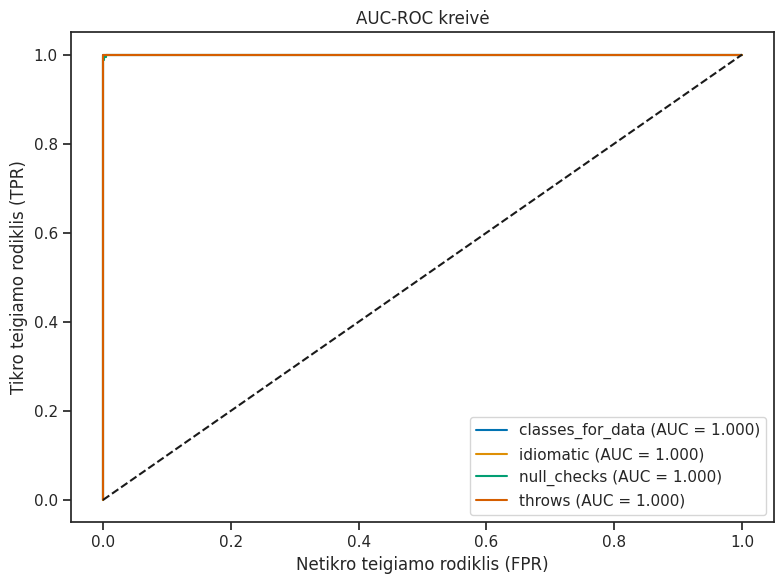

AUC-ROC kreivė išsaugota: results/notebooks/cnn/auc_roc.png


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss, roc_curve, auc
import matplotlib.pyplot as plt

tikslumas = accuracy_score(y_true, y_pred)
preciziskumas = precision_score(y_true, y_pred, average="weighted", zero_division=0)
f1_statistika = f1_score(y_true, y_pred, average="weighted")
svertine_kryzmine_entropija = log_loss(y_true, y_pred_probs)

results_df = pd.DataFrame(
    {
        "Metrika": [
            "Tikslumas",
            "Preciziškumas",
            "F1 statistika",
            "Svertinė kryžminė entropija",
        ],
        "Reikšmė": [tikslumas, preciziskumas, f1_statistika, svertine_kryzmine_entropija],
    }
)

results_path = OUTPUT_PATH / "metrics_table.tex"
results_df.to_latex(results_path, index=False, float_format="%.4f")
print(f"Metrikų lentelė išsaugota: {results_path}")

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    y_true_bin = (y_true == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_bin, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Netikro teigiamo rodiklis (FPR)")
plt.ylabel("Tikro teigiamo rodiklis (TPR)")
plt.title("AUC-ROC kreivė")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "auc_roc.png")
plt.show()
print(f"AUC-ROC kreivė išsaugota: {OUTPUT_PATH / 'auc_roc.png'}")


Modelio architektūros diagrama išsaugota: results/notebooks/cnn/model_architecture.png


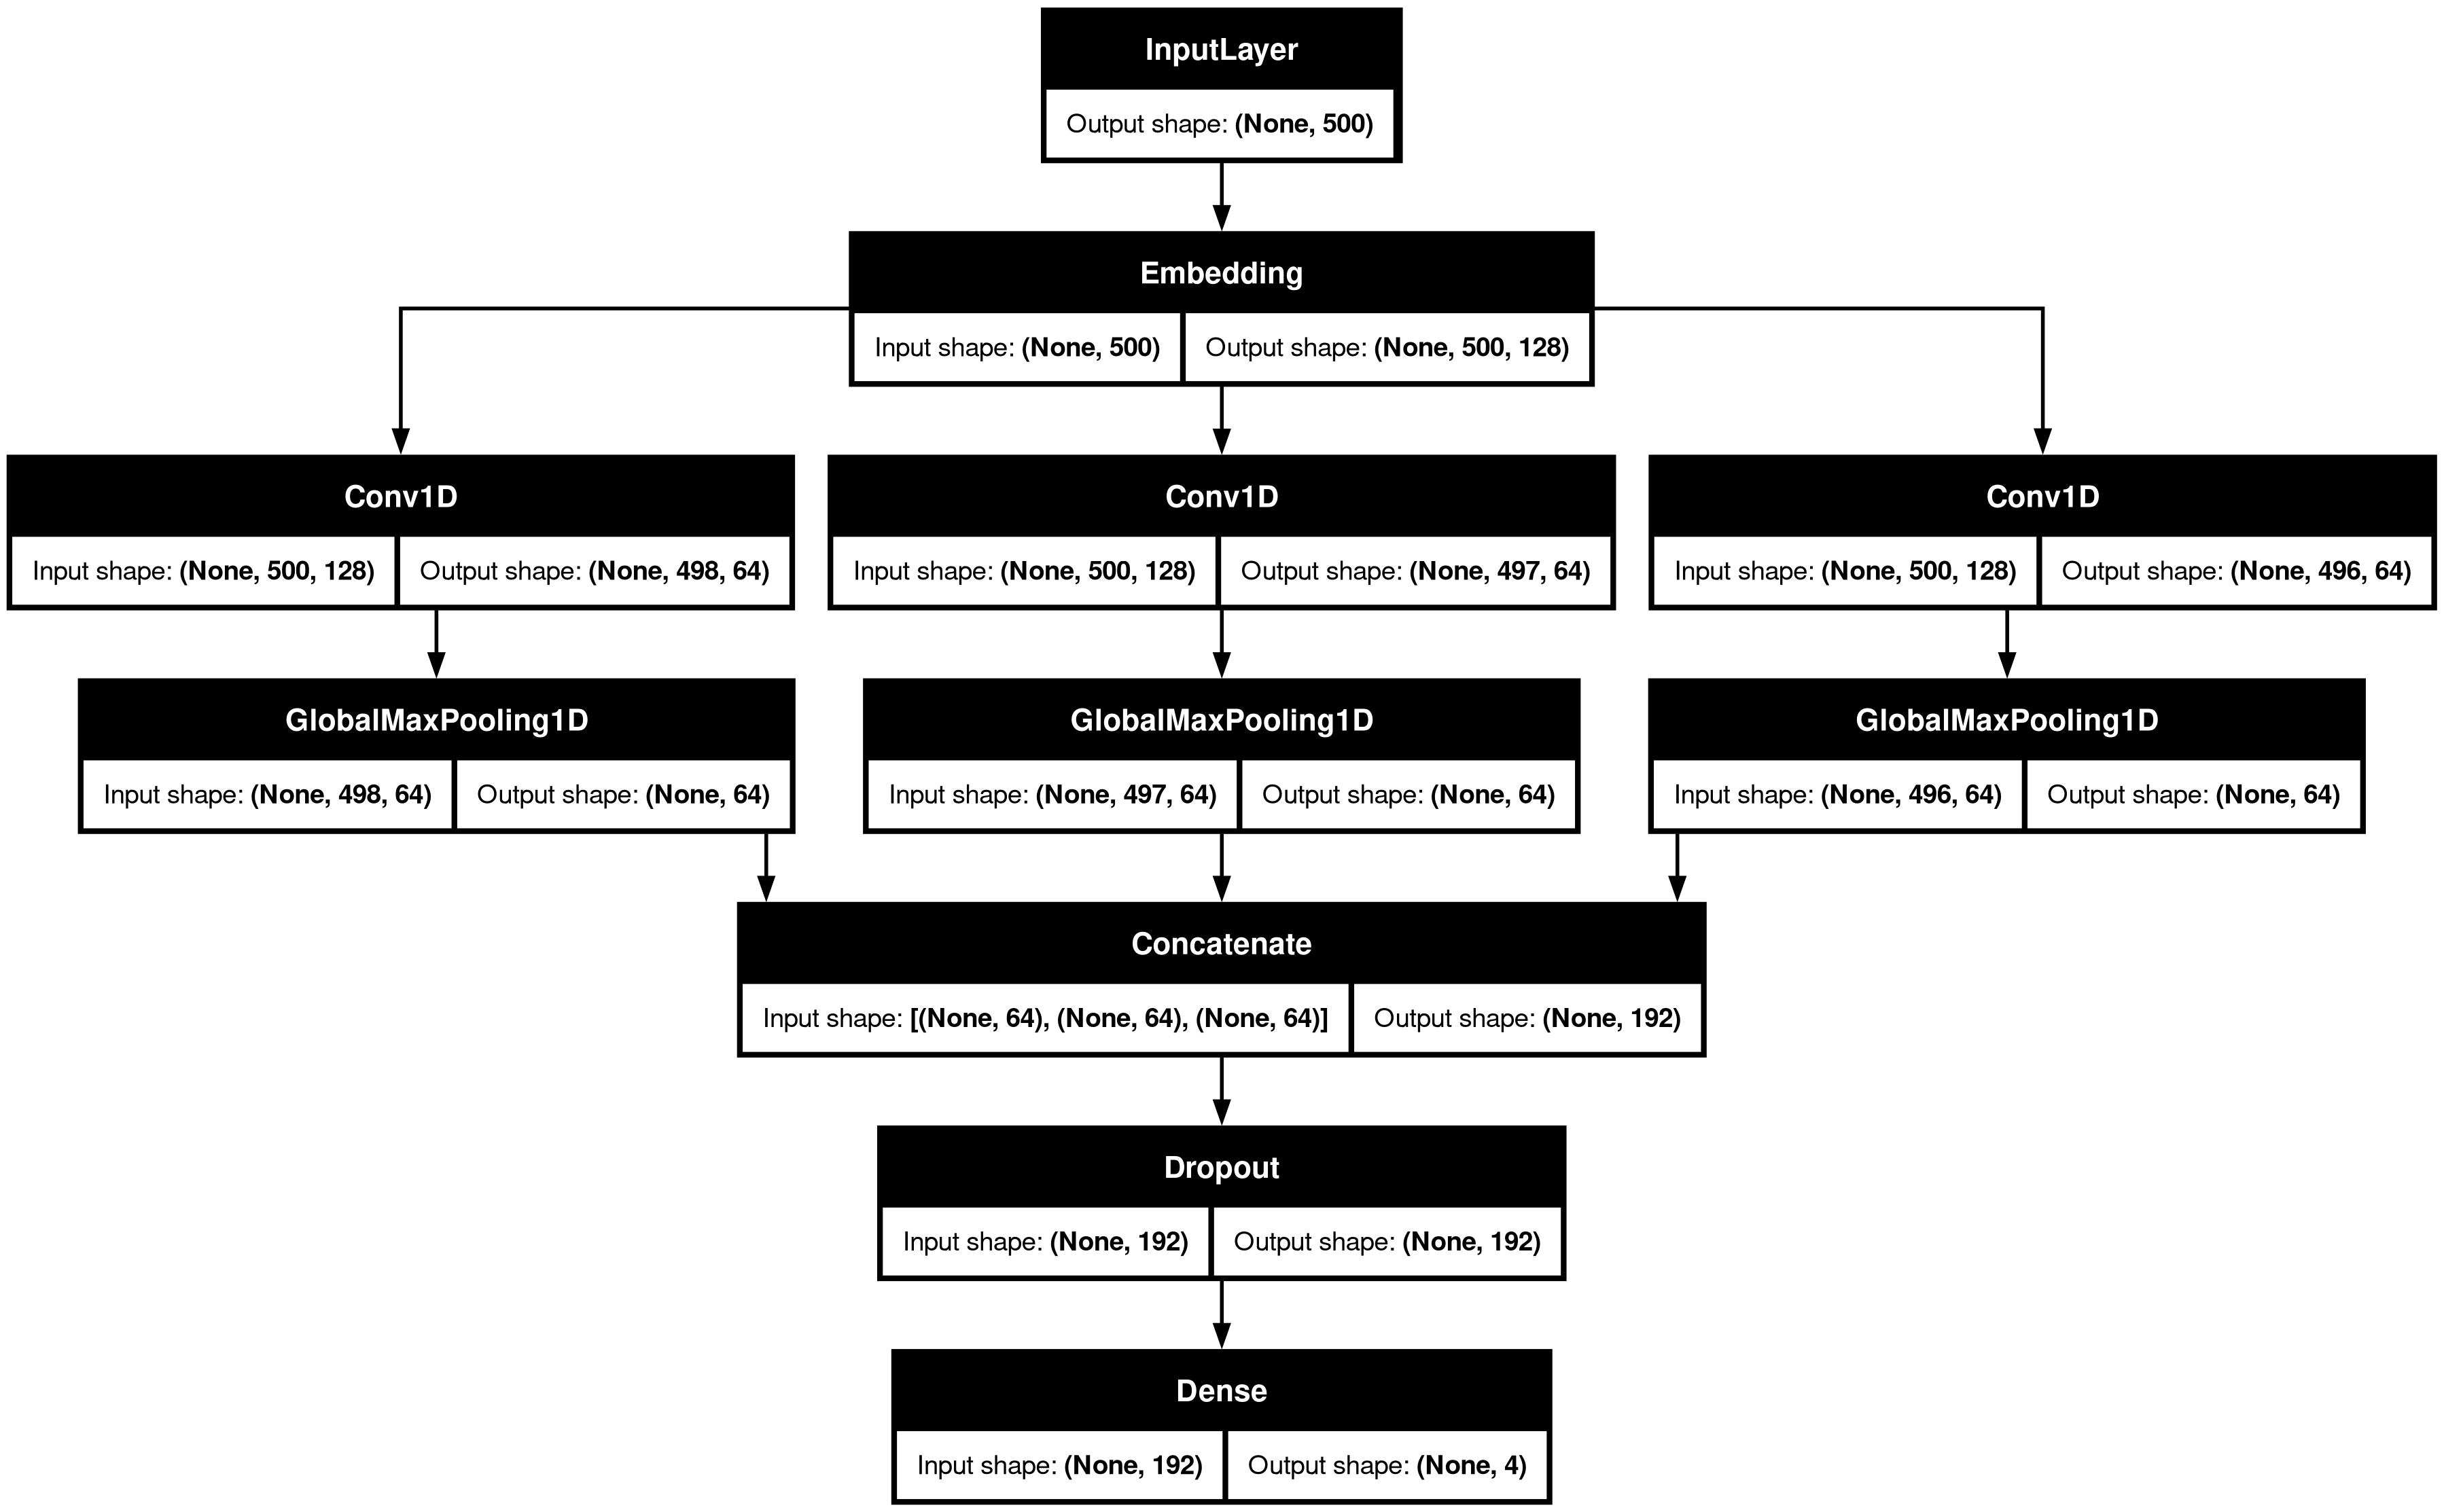

In [16]:
from IPython.display import Image, display

keras.utils.plot_model(model, to_file=str(OUTPUT_PATH / "model_architecture.png"), show_shapes=True, dpi=200)

print(f"Modelio architektūros diagrama išsaugota: {OUTPUT_PATH / 'model_architecture.png'}")
display(Image(filename=str(OUTPUT_PATH / "model_architecture.png")))